In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, average
from scipy.spatial.distance import pdist, squareform

import pandas as pd 

In this notebook, we want to understand the implementation of SPI (Spectral Phylogenetic Inference)
For this, we will use a made up dataset with some random-spot random choice mutation. 

In [87]:
### Here I will construct a dataset with self-imposed evolution through mutation of bits
Sequence_length = 60
Total_number_of_sequences = 50

Starting_seq = np.ones(Sequence_length)
Seq_list = [Starting_seq]
Seq_name = ["L0"]

for i in range(1, Total_number_of_sequences):

    Seq_i = np.copy(Seq_list[i-1])
    Seq_i_name = "L" + str(i)

    possible_spots_to_mutate = np.ravel(np.argwhere(Seq_i ==1))
    mutation_spot = int(np.random.choice(possible_spots_to_mutate, 1))  ##< At this position 1 flips to zero in the sequence
    
    if np.random.choice([0,1])==1:
        ##Mutate randomly at random spot
        Seq_i[mutation_spot] =0

    Seq_list.append(Seq_i)
    Seq_name.append(Seq_i_name)

Seq_List = np.array(Seq_list)
Seq_Name = np.array(Seq_name)

Text(0.5, 0, "${'Gene'}$ alignment (Some fake thing I made)")

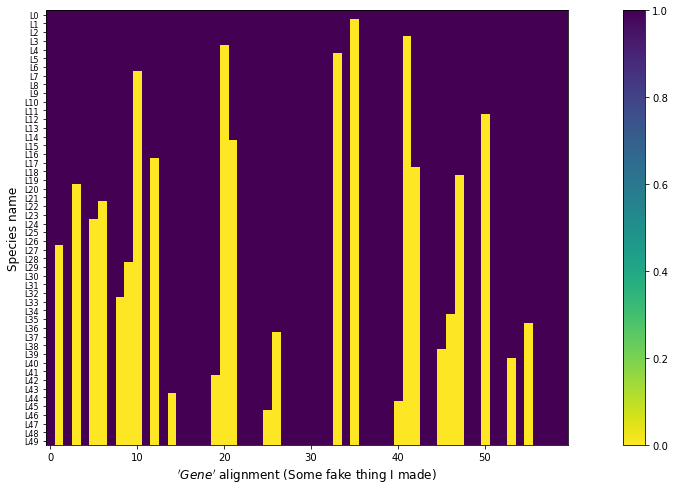

In [102]:
### Plotting to visualize the sequences

plt.figure(figsize=(20,8))
plt.imshow(Seq_List, cmap = "viridis_r")
plt.colorbar(fraction = 0.04)
plt.yticks(range(0, len(Seq_Name)), Seq_Name, fontsize = 8)
plt.ylabel("Species name", fontsize = 12)
plt.xlabel(r"${'Gene'}$ alignment (Some fake thing I made)", fontsize = 12)

First Step is Doing the Singular Value Decomposition. Since we want relatedness between species, we need it to be in rows. Hence we Perform SVD on the transpose of the data matrix.

Things to do:
1) Transpose the Data Matrix to have the relevant thing I want to make a tree of on the rows (this is already done in my case)
2) Perform Singular Value Decomposition
3) Sort the singular values.
4) Plot the sorted singular value list.

Text(0.5, 0, 'Genes')

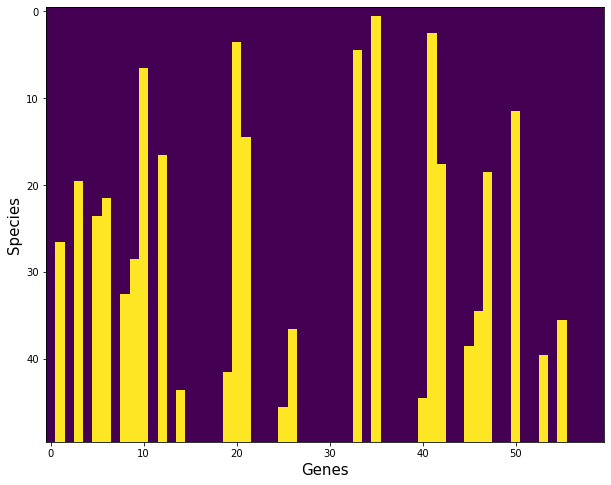

In [103]:
## First transpose the data ? (In my case, no need)
Data_matrix = Seq_List

## If transpose necessary, do the following
# Data_matrix = Seq_List.T

plt.figure(figsize =(10,8))
plt.imshow(Data_matrix, aspect = "auto", cmap = "viridis_r")
plt.ylabel("Species", fontsize = 15)
plt.xlabel("Genes", fontsize = 15)
#plt.title("Transposed Datamatrix", fontsize = 15)

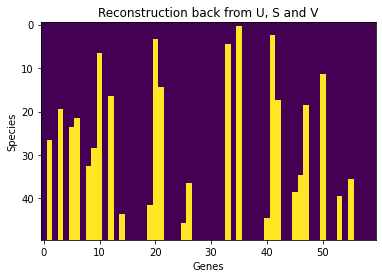

Reconstruction Works! This is the exact same dataset as the one used for SVD


In [110]:
### Now we perform the Singular Value Decomposition:
U, S,Vt = np.linalg.svd(Data_matrix)


##Reconstruction of the original matrix from SVD components
#### Data_transposed = U * Sig * Vt
#### U, Vt are square matrices
### Sig is a diagonal rectangular matrix

Sig = np.zeros(shape = (np.shape(U)[1], np.shape(Vt)[0]))   
np.fill_diagonal(Sig, S)
##########
plt.imshow(np.matmul(np.matmul(U, Sig), Vt), aspect = "auto", cmap="viridis_r")
plt.ylabel("Species")
plt.xlabel("Genes")
plt.title("Reconstruction back from U, S and V")


plt.show()
print("Reconstruction Works! This is the exact same dataset as the one used for SVD")

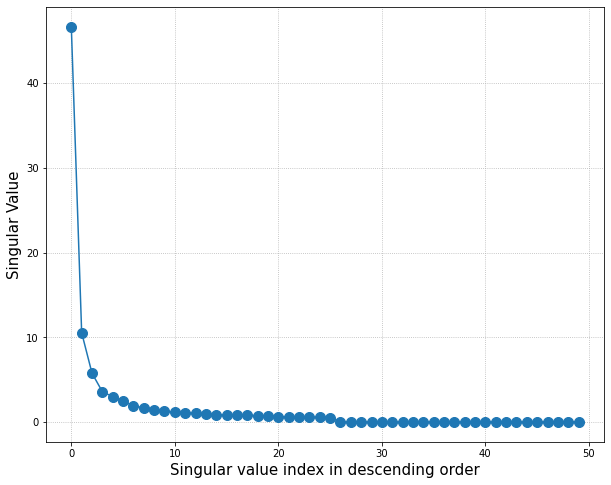

In [111]:
#Lets sort and plot the singular values
plt.figure(figsize=(10,8))
plt.plot(np.flip(np.sort(S)), "o-",ms = 10)
plt.grid(zorder = 0, linestyle = "dotted")
plt.xlabel("Singular value index in descending order", fontsize = 15)
plt.ylabel("Singular Value", fontsize = 15)
plt.show()

Great! We now need to partition the singular values into groups pertaininig to same scale. But this requires us to properly define what are the relevant scales in the data. (Think of it as some length-scale appropriate in this problem. Rather than talking about exact numbers, we can now begin to talk about multiples of this length scales which is a more natural language for this problem.)

For this, we first find the difference of log subsequent sorted singular values. This is equivalent to log of the ratios of the actual singular values.

So In the sorted singular value list, we compute the following.

$$S[i] - S[i-1] \qquad\forall \,i$$


In this list of differences, we can now use the median (or any other quartile) as a good lengthscale or the break-magnitude.

In [112]:
#### Ok, so how do we partition this? ###


## Step 1. 
### First we need to arrange singular values by magnitude. Fortunately python svd already does this for us internally.
### If that was not the case, we would do the following:
### S = np.flip(np.sort(S))

## Might need to add regularizer given small singular values tend to be polluted by machine errors.
regularizer = 1
Log_S = np.log(S+regularizer)   ### we have now regularized it

### Step 2
##Compute log difference between each subsequest singular values
### Now we need to compute (Log_S[i] - Log_S[i-1])
Difference_array = np.abs(np.diff(Log_S))   ### we need absolute value because np.diff calculates Log_S[i+1] = Log_S[i]

#### Now that we have the difference array, we want to find places where the subsequent singular value magnitude drops sharply 
### (i.e Difference_array < some value).
### This begs the question, what is a sharp drop?
### We can answer this question in many ways, Here, we choose a drop that is larger than alpha * median_differnce 
### we can choose any quartile for that matter. median just is easy
### alpha <=1 
alpha = 1.0
break_magnitude = alpha * np.quantile(Difference_array, q = 0.5)     #### quantile is a more general function, setting q = 0.5 gives median

print(break_magnitude)

0.0038277726663115685


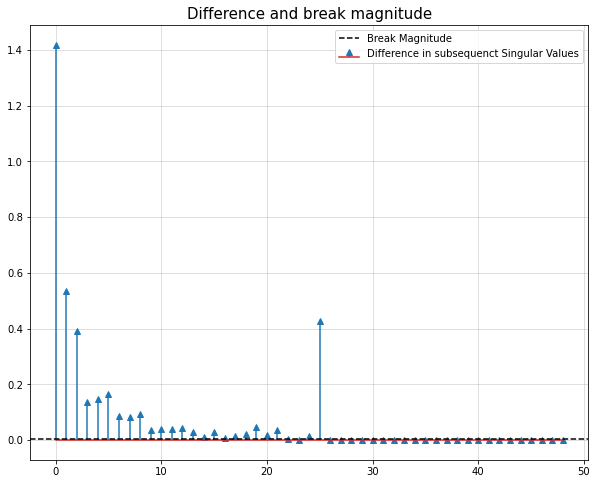

In [115]:
plt.figure(figsize=(10,8))
plt.stem(np.arange(0,len(Difference_array),1),Difference_array, label = "Difference in subsequenct Singular Values", bottom=0, markerfmt="^")
plt.axhline(break_magnitude, color = "black",linestyle="--", label = "Break Magnitude")
plt.grid(alpha = 0.5, zorder = 0)
plt.title("Difference and break magnitude", fontsize = 15)
plt.legend()

How are the intervals formed?
If a difference value (as plotted above) is larger than this break-magnitude, the associated $S[i]$ is kept in its own class. If several subsequent differences are smaller than the break magnitude, they are lumped together and kept in their own class along with the next large $S[i]$. 
So, visually we can see that S[0], S[1], S[2] form their individual intervals while (S[32], S[32],S[34]]) form a collective interval.

In [116]:
## This can be formalized as
def Intervals (S , alpha =1.0, q = 0.5, reg = 1):
    ### regularize S and take log:
    ### sort S in descending order if not sorted already
    Log_S_reg = np.log(S+reg)
    ### Compute log difference:
    ### we need absolute value because np.diff calculates Log_S[i+1] = Log_S[i]
    Log_diff = np.abs(np.diff(Log_S_reg))
    
    ### Figure out break magnitude ~ median of log difference
    break_magnitude = alpha * np.quantile(Log_diff,q)

    ### See where difference exceeds break magnitude
    break_position = np.ravel(np.argwhere(Log_diff > break_magnitude) +1)
    
    ### Start and end of interval based on break position
    Start = np.concatenate(([0], break_position))
    End = np.concatenate((break_position, [len(S)]))


    Interval = []
    for start, end in zip(Start, End):
        Interval.append(range(start, end))
    
    return Interval

In [117]:
Interval= Intervals(S, reg=regularizer)

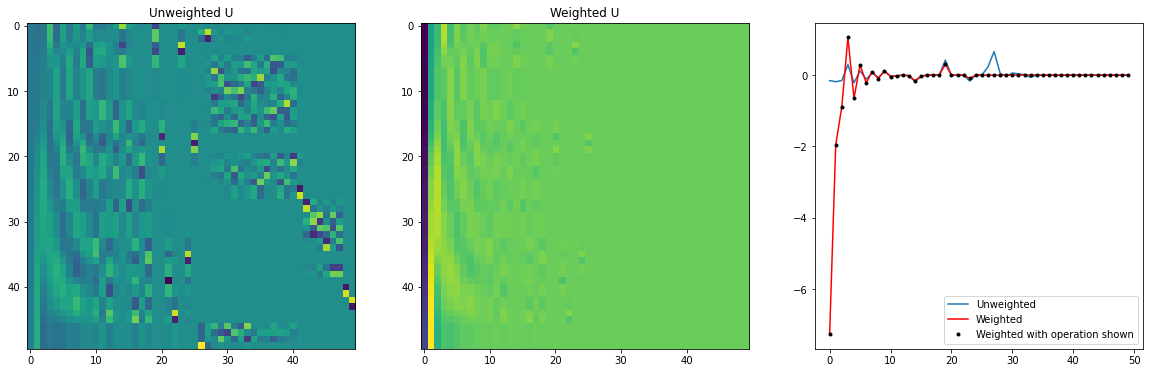

In [118]:
#### Now we need to sum within the interval to get the distance:
### First --> Multiply  U and Sigma to get weighted vectors:

Weighted_U_vecs = np.matmul(U, np.diag(S))

k = 1
fig, ax= plt.subplots(1,3, figsize=(20,6))
ax[0].imshow(U,aspect = "auto")
ax[0].set_title("Unweighted U")
ax[1].imshow(Weighted_U_vecs, aspect = "auto")
ax[1].set_title("Weighted U")
ax[2].plot(U[k], label = "Unweighted")
ax[2].plot(Weighted_U_vecs[k], color = "red", label = "Weighted")
ax[2].plot(U[k]*S, ".", label = "Weighted with operation shown", color = "black")
ax[2].legend()

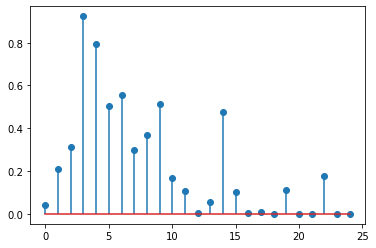

In [119]:
#### Ok, can I do this distance calculation manually?
j = 5
k = 1
Distance_distribution = []
total_dist =0

for interv in Interval:
    ### Get coordinates:
    V_int = Weighted_U_vecs[:,interv]
    coord_j= V_int[j]
    coord_k = V_int[k]
    dist = np.linalg.norm(coord_j - coord_k, ord=2)  #<< L2 norm
    total_dist+= dist
    Distance_distribution.append(dist)


#print("My calc= ",total_dist,"--->","SPI calc= ",sprmtx[j,k])
plt.stem(Distance_distribution)
plt.show()

In [120]:
### This is how the distance matrix is calculated 
from scipy.spatial.distance import pdist

Distance_distribution = []
#total_dist =0

for interv in Interval:
    ### Get coordinates:
    V_int = Weighted_U_vecs[:,interv]
    dist = pdist(V_int, "euclidean")
    #total_dist+= dist
    Distance_distribution.append(dist)

## My distance distribution has the distances between each pair of features within any given interval.
## I can use a scipy.spatial.distance.squareform to convert these distance vectors into a distance matrix
## There are a lot of redundancies in the distance vector since d_ij = d_ji
## squareform understands this
Distance_Matrix = np.zeros(shape = np.shape(U))
for dist_vct in Distance_distribution:
    dist_matrix = squareform(dist_vct)
    Distance_Matrix+=dist_matrix

Dist_squared = Distance_Matrix**2

Text(0.5, 1.0, 'The Distance Matrix between Species')

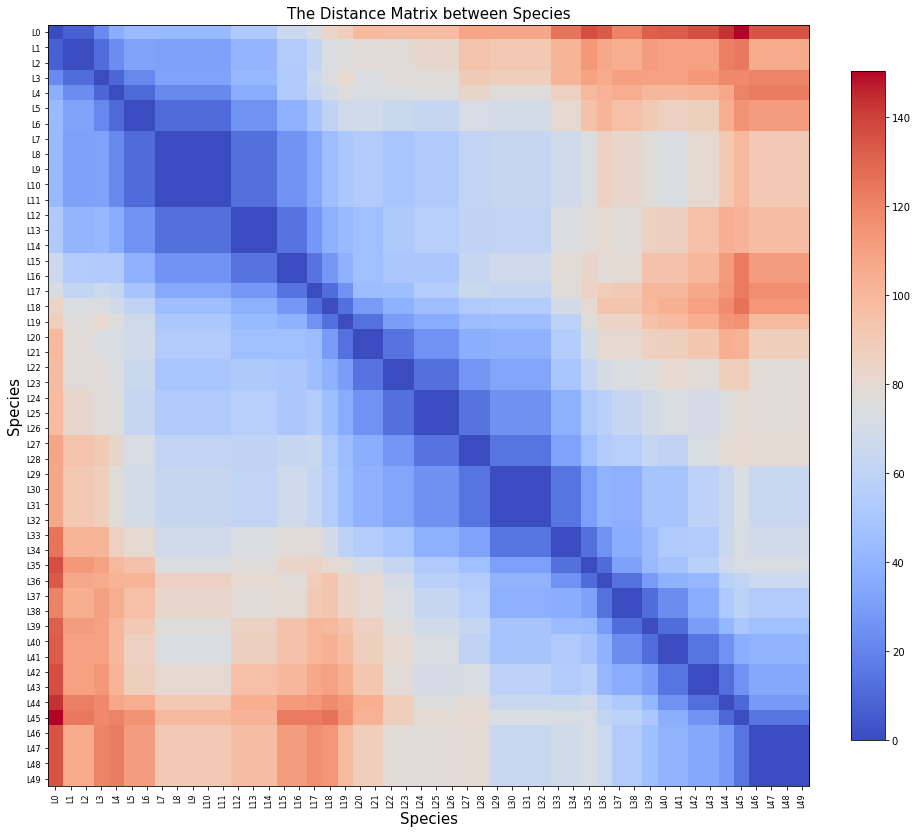

In [137]:
plt.figure(figsize=(15,15))
plt.imshow(Dist_squared, cmap="coolwarm")
plt.colorbar(fraction = 0.04)
plt.ylabel("Species", fontsize = 15)
plt.xticks(range(0, len(Seq_Name)),Seq_Name, fontsize = 8, rotation = 90)
plt.yticks(range(0, len(Seq_Name)),Seq_Name, fontsize = 8)
plt.xlabel("Species", fontsize = 15)
plt.title("The Distance Matrix between Species", fontsize = 15)

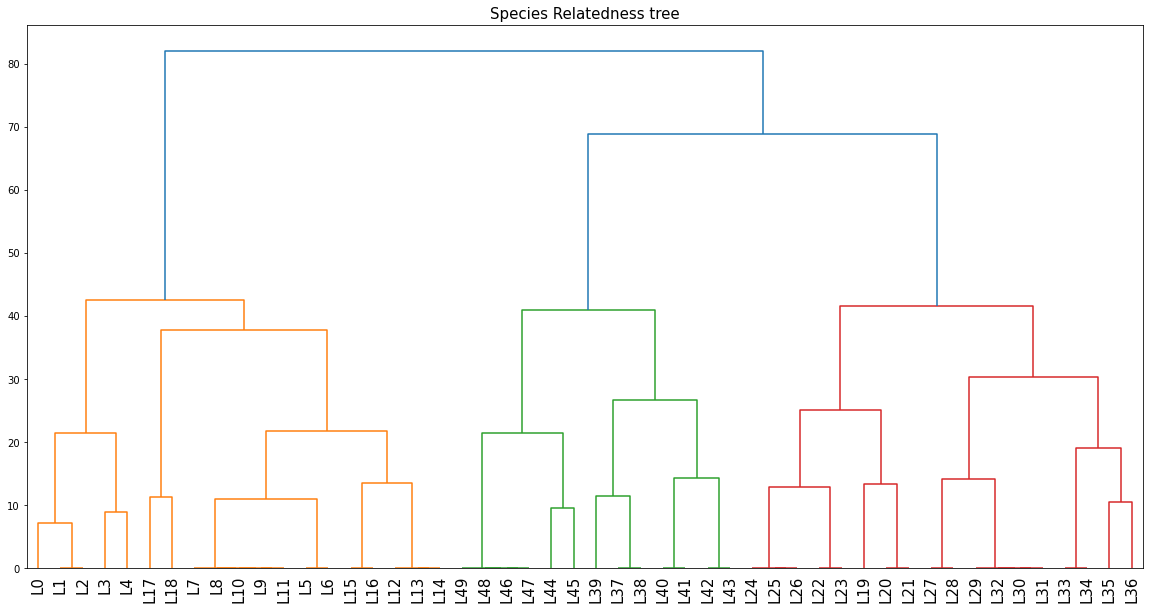

In [130]:
#### Now we make the tree
#### 
from scipy.cluster.hierarchy import linkage, dendrogram, average

Condensed_dist_matrix = squareform(Dist_squared)   ## This is the upper triangle of the distance matrix

## We construct a linkage matrix form this.

Linkage_matrix = linkage(Condensed_dist_matrix, method="average")

### We construct a tree diagram from the Linkage Matrix

plt.figure(figsize=(20,10))
Dend = dendrogram(Linkage_matrix, labels = Seq_Name)
plt.xticks(rotation = 90, fontsize=15)
#plt.ylim(0,100)

plt.title("Species Relatedness tree", fontsize = 15)
plt.show()





In [142]:


#### Code from Doran et. al. ######
## These are the SPI codes - just the relevant ones for distance calculation and tree building from Ben's code


def getintervals(S: np.ndarray, alpha: float = 1.0, q: float = .5): #-> List[range]:
    """
    finds spectral partitions. Computes log difference between each subsequent singular
    value and by default selects the differences that are larger than `1.0 * Q2(differences)`
    i.e. finds breaks in the spectrum that explain smaller scales of variance

    Args:
    * S = singular values of a SVD factorization
    * alpha = scalar multiple of `q`
    * q = which quantile of log differences to use; by default Q2

    Returns:
    * AbstractVector{UnitRange} indices into S corresponding to the spectral partitions
    """
    # Compute the log difference between each subsequent singular value
    potentialbreaks = abs(np.diff(np.log(S+1)))
    # Compute the quantile of the log differences
    θ = alpha * np.quantile(potentialbreaks, q)
    # Find all log differences that are greater than θ
    breaks = np.argwhere(potentialbreaks > θ).flatten() + 1
    # Concatenate the indices of the breaks with the start and end indices
    starts, ends = np.concatenate(([0], breaks)), np.concatenate((breaks, [len(S)]))
    # Create a list of ranges from the starts and ends indices
    intervals = [range(s, e) for s, e in zip(starts, ends)]
    return intervals


from scipy.spatial.distance import pdist, squareform
from scipy.special import comb

def calc_spi_mtx(vecs: np.ndarray, vals: np.ndarray, intervals):
    """
    computes the cumulative spectral residual distance for spectral phylogenetic inference
    ```(∑_{p ∈ P} ||UₚΣₚ||₂)²```
    where ``P`` are the spectral partitions found with `getintervals`.

    Args:
    * A,usv = AbstractMatrix or SVD factorization (AbstractMatrix is just passed to `svd()` before calculation)
    * SPI.Left() computes SPI matrix for LSVs; SPI.Right() computes SPI matrix for RSVs
    * alpha, q are passed to `getintervals()` see its documentation

    Returns:
    * distance matrix
    """
    # Initialize the matrix of squared spectral partition distances with zeros
    sprmtx = np.zeros((vecs.shape[0], vecs.shape[0]))
    # weight components by singular values
    wvecs = vecs @ np.diag(vals)
    for grp in intervals:
        # Compute the pairwise weighted Euclidean distance between the rows of vecs for the indices in grp
        sprmtx += squareform(pdist(wvecs[:, grp], "euclidean"))
    return sprmtx**2


def UPGMA_tree(Dij: np.ndarray) -> np.ndarray:
    """
    shorthand for `scipy.cluster.hierarchy.average(squareform(Dij))`
    """
    import scipy
    return scipy.cluster.hierarchy.average(squareform(Dij))

In [143]:
Interval_code = getintervals(S)
Distance_matrix_code = calc_spi_mtx(U, S, Interval_code)
Linkage_matrix_code = UPGMA_tree(Distance_matrix_code)

Text(0.5, 1.0, 'Distance matrix from SPI code- Doran et al')

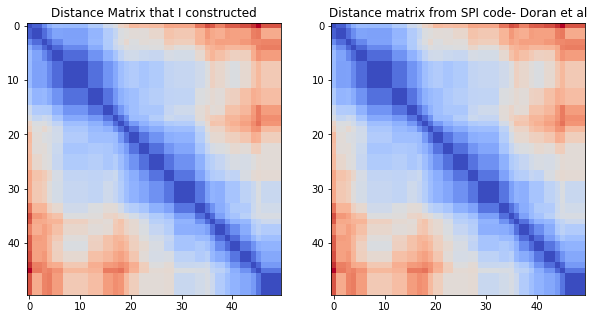

In [144]:
fig, ax = plt.subplots(1,2, figsize= (10,5))
ax[0].imshow(Dist_squared, aspect = "auto", cmap = "coolwarm")
ax[0].set_title("Distance Matrix that I constructed")
ax[1].imshow(Distance_matrix_code, aspect = "auto", cmap = "coolwarm")
ax[1].set_title("Distance matrix from SPI code- Doran et al")

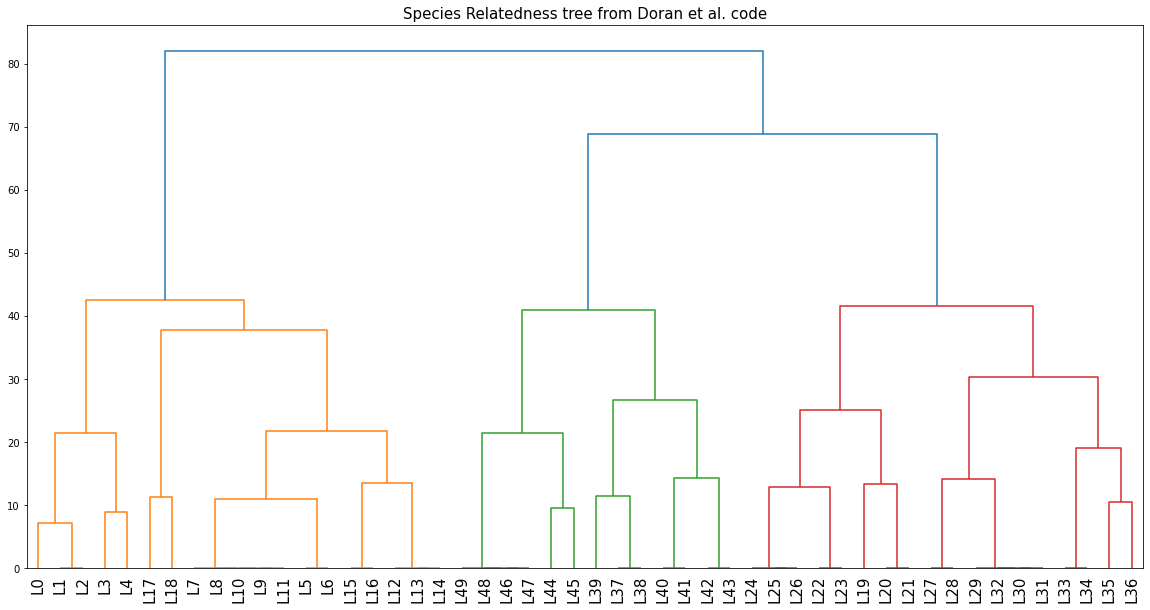

In [145]:
plt.figure(figsize=(20,10))
Dend = dendrogram(Linkage_matrix_code, labels = Seq_Name)
plt.xticks(rotation = 90, fontsize=15)
#plt.ylim(0,100)

plt.title("Species Relatedness tree from Doran et al. code", fontsize = 15)
plt.show()

Text(0.5, 1.0, 'Tree from Doran et al. code')

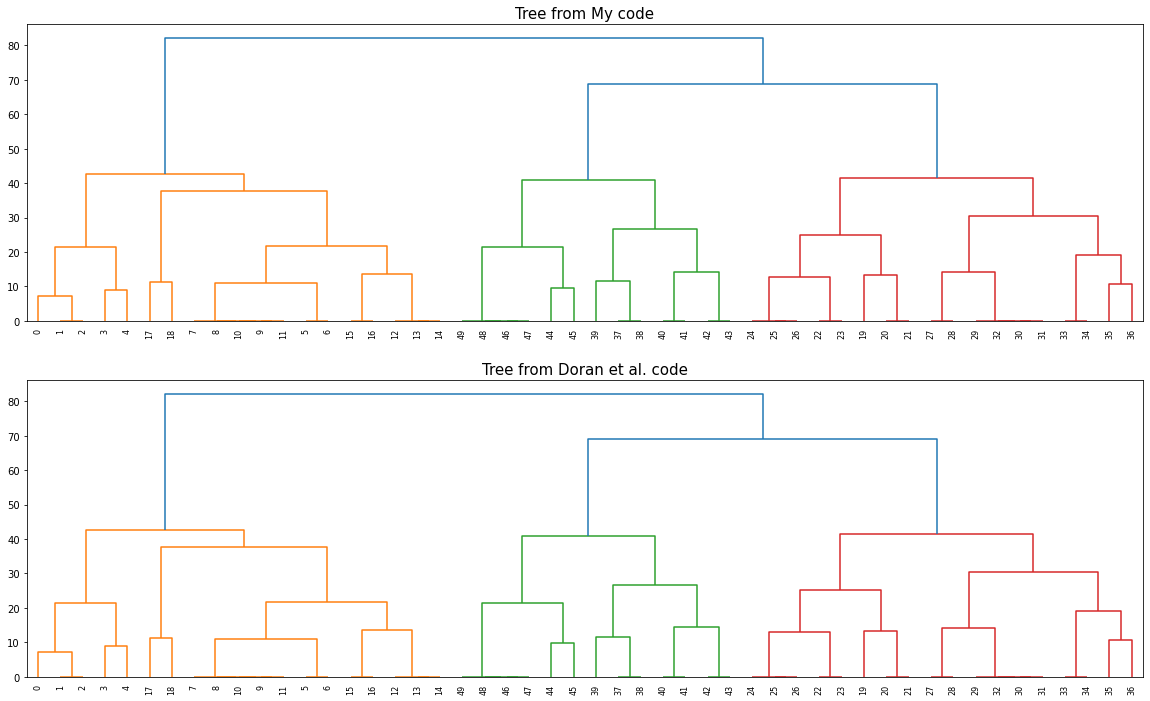

In [146]:
# Plotting both my tree and SPI tree together.
fig, ax = plt.subplots(2,1, figsize=(20,12))
dend=dendrogram(Linkage_matrix,ax=ax[0])
ax[0].set_title("Tree from My code", fontsize = 15)
dend_code = dendrogram(Linkage_matrix_code, ax = ax[1])
ax[1].set_title("Tree from Doran et al. code", fontsize = 15)